In [31]:
%matplotlib inline
# common functions used in the project of VR-R in GAC direction
import numpy as np
#import scipy.linalg as splin
import numpy.linalg as nl
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick',labelsize=12)
matplotlib.rc('ytick',labelsize=12)
font = {'size' : 20}
matplotlib.rc('font', **font)
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.optimize import curve_fit
import scipy.stats as stats
import scipy.special as special
import astropy.io.fits as fits
import emcee
import corner
# f = open('/Users/htian/Documents/work/data/rothalo/fevrvtvz.dat')
# VT = f.readlines()
# f.close()

(array([   1.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    1.,    1.,    1.,    2.,    1.,    2.,
           1.,    0.,    2.,    0.,    3.,    4.,    0.,    0.,    3.,
           3.,    3.,    7.,    5.,    7.,    5.,   12.,   19.,   17.,
          23.,   28.,   28.,   30.,   30.,   49.,   69.,   80.,   81.,
          92.,   84.,  124.,  104.,  175.,  141.,  214.,  200.,  243.,
         232.,  214.,  237.,  201.,  208.,  216.,  219.,  181.,  152.,
         166.,  153.,  172.,  162.,  171.,  154.,  167.,  171.,  134.,
         124.,  151.,  157.,  137.,  115.,  102.,  110.,   87.,   77.,
          66.,   63.,   39.,   27.,   23.,   10.,    5.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([-466.12384  , -457.5075646, -448.8912892, -440.2750138,
        -431.6587384, -423.042463 , -414.4261876, -405.8099122,
        -397.1936368, -388.5773614, -379.961086 , -371.3448106,
        -362.72853

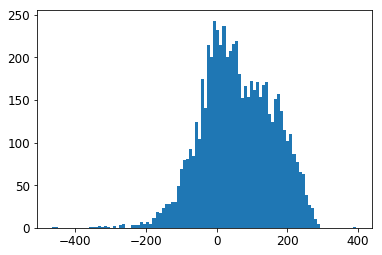

In [2]:
data = np.loadtxt('/Users/htian/Documents/work/data/rothalo/fevrvtvz.dat')
vt = data[:,2]
feh = data[:,0]
plt.hist(vt,100)
# plt.show()

In [3]:

def MC_error(x,err):
    return np.random.normal(loc=x,scale=err)
   
def straightline(x,a,b):
    '''
    Straightline function
    '''
    return a + b*x

#Calculate velocity distribution at each bin, using Bayesian model
def gaussian(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
#hierachical Beyasian model

def gauss_model(y):
    # sampling
    n = len(y)
    y_bar = np.mean(y)
    s2 = np.var(y)
    
    #step 1: draw sigma2 from posterior density of 
    #        sigma2 given v, p(sigma2|y)
    N = 5000
    sigma2 = randDraw_SInvChi2(n-1,s2, N)
    #step 2 : draw mu from p(mu|sigma2,y)
    mu = np.random.normal(loc=y_bar, \
            scale=np.sqrt(sigma2/n))
    popt = np.array([n,np.mean(mu),np.mean(np.sqrt(sigma2))])
    pcov = np.array([[1.0,0.0,0.0],[0.0,np.var(mu),0.0],\
                     [0.0,0.0,np.var(np.sqrt(sigma2))]])
    return popt, pcov

def lnprob_gauss(x,y):
    mu1 = x[0]
    sig1 = x[1]
    if np.isinf(mu1) or np.isinf(sig1) or sig1<0 or\
               np.abs(mu1)>100 :
        return -1e50
    g = stats.norm.pdf(y,mu1,sig1)# np.exp(-(y-mu1)**2/(2*sig1**2))/(np.sqrt(2*np.pi)*sig1)
    ind_g = (np.isinf(g)==False) & (np.isnan(g)==False) & (g>0)
    return np.sum(np.log(g[ind_g]))

def gauss_mcmcmodel(y):
    # MCMC sampling
    #n = len(y)
    
    #start to configure emcee
    nwalkers = 20
    ndim = 2
    p0=np.zeros((nwalkers,ndim))
    p0[:,0] = np.random.rand(nwalkers)*50-25
    p0[:,1] = np.random.rand(nwalkers)*40+20
      
    sampler = emcee.EnsembleSampler(nwalkers, \
            ndim, lnprob_gauss, args=[y])
    
    pos, prob, state = sampler.run_mcmc(p0, 100)
    sampler.reset()
    
    sampler.run_mcmc(pos, 10000)
    
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
    #corner.corner(samples)
    popt = np.median(samples, axis=0)
    pcov = np.zeros((ndim,ndim))
    for i in range(ndim):
        for j in range(ndim):
            pcov[i,j] = (np.sum((samples[:,i]-popt[i])*\
                (samples[:,j]-popt[j])))/len(samples)
    return popt, pcov


def lnprob_gauss2(x,y):
    #n = np.float(len(y))
    f1 = x[0]
    mu1 = x[1]
    sig1 = x[2]
    mu2 = x[3]
    sig2 = x[4]
    if np.isinf(f1) or np.isinf(mu1) or np.isinf(sig1) or\
                np.isinf(mu2) or np.isinf(sig2) or\
                f1<0 or f1>1 or sig1<0 or sig2<0 or\
                sig1>200 or sig2>200 or\
                mu1>100 or mu1<-50 or mu2>300 or mu2<100:
        return -1e100
    g1 = f1*stats.norm.pdf(y,mu1,sig1)# np.exp(-(y-mu1)**2/(2*sig1**2))/(np.sqrt(2*np.pi)*sig1)
    g2 = (1-f1)*stats.norm.pdf(y,mu2,sig2)#np.exp(-(y-mu2)**2/(2*sig2**2))/(np.sqrt(2*np.pi)*sig2)
    g = g1+g2
    #print g
    ind_g = (np.isinf(g)==False) & (np.isnan(g)==False) & (g>0)
    logg = np.log(g[ind_g])
    ind_lg = logg>-1e100
    return np.sum(logg[ind_lg])

def gauss2_model(y,p0,N, func, nwalkers):
    # MCMC sampling
    ndim = p0.shape[1]
    print(ndim)
    sampler = emcee.EnsembleSampler(nwalkers, \
            ndim, func, args=[y])
    N_burn_in = 2000
    
    pos, prob, state = sampler.run_mcmc(p0, N_burn_in)
    sampler.reset()
    
    sampler.run_mcmc(pos, N)
    
    samples = sampler.chain[:, N_burn_in:, :].reshape((-1, ndim))
    #corner.corner(samples)
    popt = np.median(samples, axis=0)
    pcov = np.zeros((ndim,ndim))
    for i in range(ndim):
        for j in range(ndim):
            pcov[i,j] = (np.sum((samples[:,i]-popt[i])*\
                (samples[:,j]-popt[j])))/len(samples)
    return popt, pcov, samples

import time

In [4]:
nwalkers = 50
ndim = 5
p0=np.zeros((nwalkers,ndim))
p0[:,0] = np.random.rand(nwalkers)*0.2+0.5
p0[:,1] = np.random.rand(nwalkers)*100-50
p0[:,2] = np.random.rand(nwalkers)*40+60
p0[:,3] = np.random.rand(nwalkers)*100+100
p0[:,4] = np.random.rand(nwalkers)*60+40
start = time.time()
Mpopt,Mpcov, samples = gauss2_model(vt, p0, 5000, lnprob_gauss2, nwalkers)
print(time.time()-start)

5
230.51041388511658


[ 0.01467825  2.47081098  1.41115615  2.97615722  1.90524844]
f=0.837\pm0.015
v_1=33 \pm 2 km/s,\sigma_1=88 \pm 1 km/s
v_2=188 \pm 3 km/s,\sigma_2=41 \pm 2 km/s


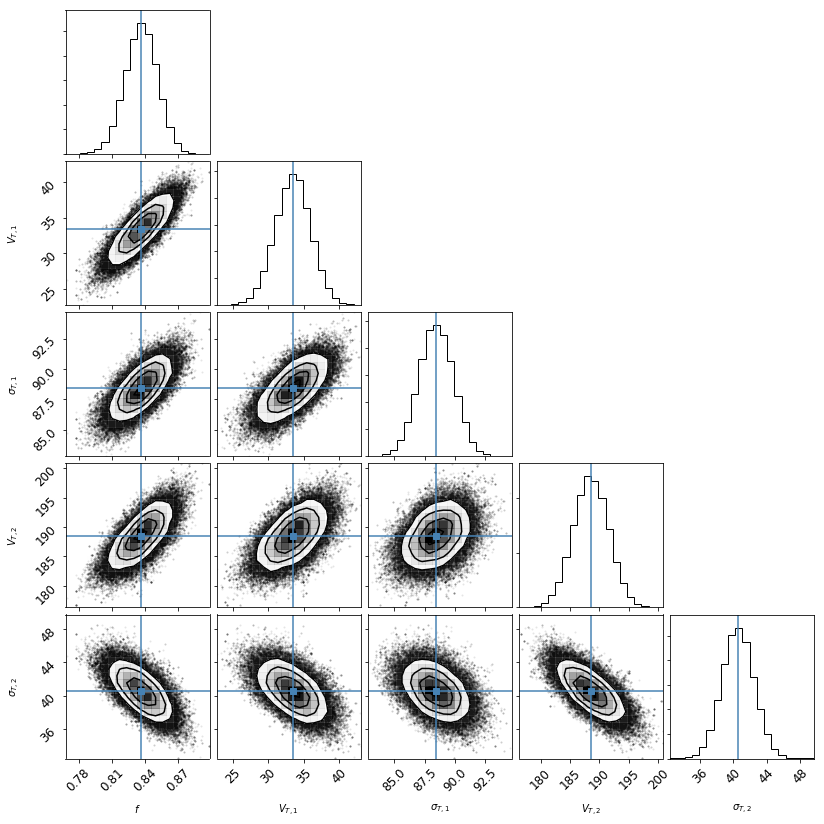

In [5]:
import corner
ss = np.sqrt(np.diag(Mpcov))
print(ss)
print('f=%(f).3f\pm%(fe).3f' % {'f':Mpopt[0],'fe':ss[0]})
print('v_1=%(v1).0f \pm %(v1e).0f km/s,\sigma_1=%(s1).0f \pm %(s1e).0f km/s' % {'v1':Mpopt[1],'v1e':ss[1],\
                                                    's1':Mpopt[2],'s1e':ss[2]})
print('v_2=%(v2).0f \pm %(v2e).0f km/s,\sigma_2=%(s2).0f \pm %(s2e).0f km/s' % {'v2':Mpopt[3],'v2e':ss[3],\
                                                    's2':Mpopt[4],'s2e':ss[4]})
fig = corner.corner(samples,labels=["$f$","$V_{T,1}$","$\sigma_{T,1}$","$V_{T,2}$","$\sigma_{T,2}$"],\
                   truths=Mpopt)

/Users/htian/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


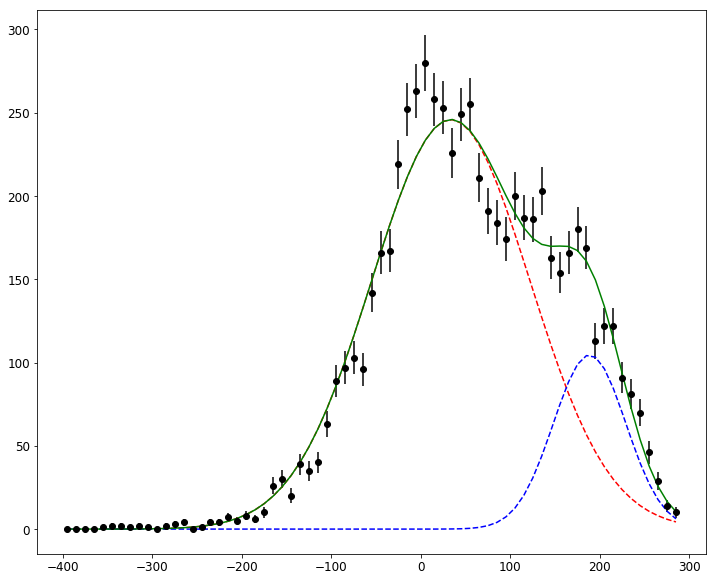

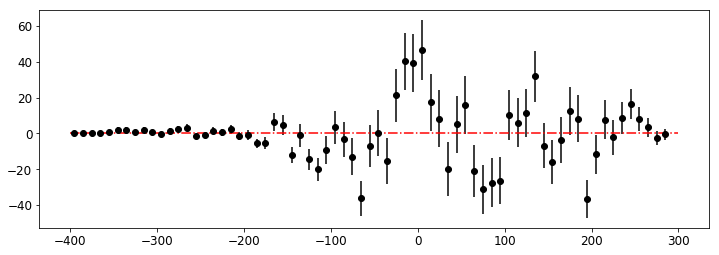

In [6]:
vgrid = np.arange(-400,300,10.)
vcenter = (vgrid[:-1]+vgrid[1:])/2.
fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(111)
h,xedge = np.histogram(vt,vgrid)
ax.errorbar(vcenter, h, yerr=np.sqrt(h),fmt='ko')
g1 = Mpopt[0]*stats.norm.pdf(vcenter,Mpopt[1],Mpopt[2])
g2 = (1-Mpopt[0])*stats.norm.pdf(vcenter,Mpopt[3],Mpopt[4])
g = g1+g2
ax.plot(vcenter, g1/np.sum(g)*np.sum(h),'r--')
ax.plot(vcenter, g2/np.sum(g)*np.sum(h),'b--')
ax.plot(vcenter, g/np.sum(g)*np.sum(h),'g-')

fig.show()
fig = plt.figure(figsize=[12,4])
ax = fig.add_subplot(111)
ax.errorbar(vcenter, h-g/np.sum(g)*np.sum(h),yerr=np.sqrt(h),fmt='ko')
ax.plot([-400,300],[0,0],'r-.')
fig.show()

In [7]:
nx = np.sum(vt<0)
ny = np.float(len(vt))
print(nx/ny*2.)
print(np.sqrt(nx*(nx+ny)/ny**3)*2.*5.)

0.588307692308
0.0765285599138


In [8]:
def lnprob_gauss3(x,y):
    #n = np.float(len(y))
    f1 = x[0]
    f2 = x[1]
    mu1 = x[2]
    sig1 = x[3]
    mu2 = x[4]
    sig2 = x[5]
    mu3 = x[6]
    sig3 = x[7]
    
    if np.isinf(f1) or np.isinf(f2) or np.isinf(mu1) or np.isinf(sig1) or\
                np.isinf(mu2) or np.isinf(sig2) or np.isinf(mu3) or np.isinf(sig3) or\
                f1<0 or f1>1 or f2<0 or f2>1 or (f1+f2)<0 or (f1+f2)>1 or\
                sig1<0 or sig2<0 or sig3<0 or\
                sig1>200 or sig2>200 or sig3>200 or\
                mu1>100 or mu1<-100 or mu3>100 or mu3<-100 or mu2>300 or mu2<100:
        return -1e100
    g1 = f1*stats.norm.pdf(y,mu1,sig1)# np.exp(-(y-mu1)**2/(2*sig1**2))/(np.sqrt(2*np.pi)*sig1)
    g2 = f2*stats.norm.pdf(y,mu2,sig2)#np.exp(-(y-mu2)**2/(2*sig2**2))/(np.sqrt(2*np.pi)*sig2)
    g3 = (1-f1-f2)*stats.norm.pdf(y,mu3,sig3)#np.exp(-(y-mu2)**2/(2*sig2**2))/(np.sqrt(2*np.pi)*sig2)
    g = g1+g2+g3
    #print g
    ind_g = (np.isinf(g)==False) & (np.isnan(g)==False) & (g>0)
    logg = np.log(g[ind_g])
    ind_lg = logg>-1e100
    return np.sum(logg[ind_lg])
print(lnprob_gauss3([0.6,0.1,30.,80.,180.,60,20,30.],vt))

-39704.577971


In [9]:
nwalkers = 50
ndim = 8
p0=np.zeros((nwalkers,ndim))
p0[:,0] = np.random.rand(nwalkers)*0.2+0.5
p0[:,1] = np.random.rand(nwalkers)*0.2
p0[:,2] = np.random.rand(nwalkers)*100-50
p0[:,3] = np.random.rand(nwalkers)*40+60
p0[:,4] = np.random.rand(nwalkers)*60+140
p0[:,5] = np.random.rand(nwalkers)*50+20
p0[:,6] = np.random.rand(nwalkers)*60-80
p0[:,7] = np.random.rand(nwalkers)*200
start = time.time()
Mpopt3,Mpcov3, samples3 = gauss2_model(vt, p0, 5000, lnprob_gauss3, nwalkers)
print(time.time()-start)

8
308.54323410987854


[  3.36393453e-02   2.19102465e-02   3.18486731e+00   2.89866802e+00
   3.81481593e+00   1.99313838e+00   2.22808873e+01   1.39013197e+01]
f_1=0.722\pm0.034,f_2=0.239\pm0.022,
v_1=25 \pm 3 km/s,\sigma_1=75 \pm 3 km/s
v_2=180 \pm 4 km/s,\sigma_2=45 \pm 2 km/s
v_3=-56 \pm 22 km/s,\sigma_3=136 \pm 14 km/s


/Users/htian/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


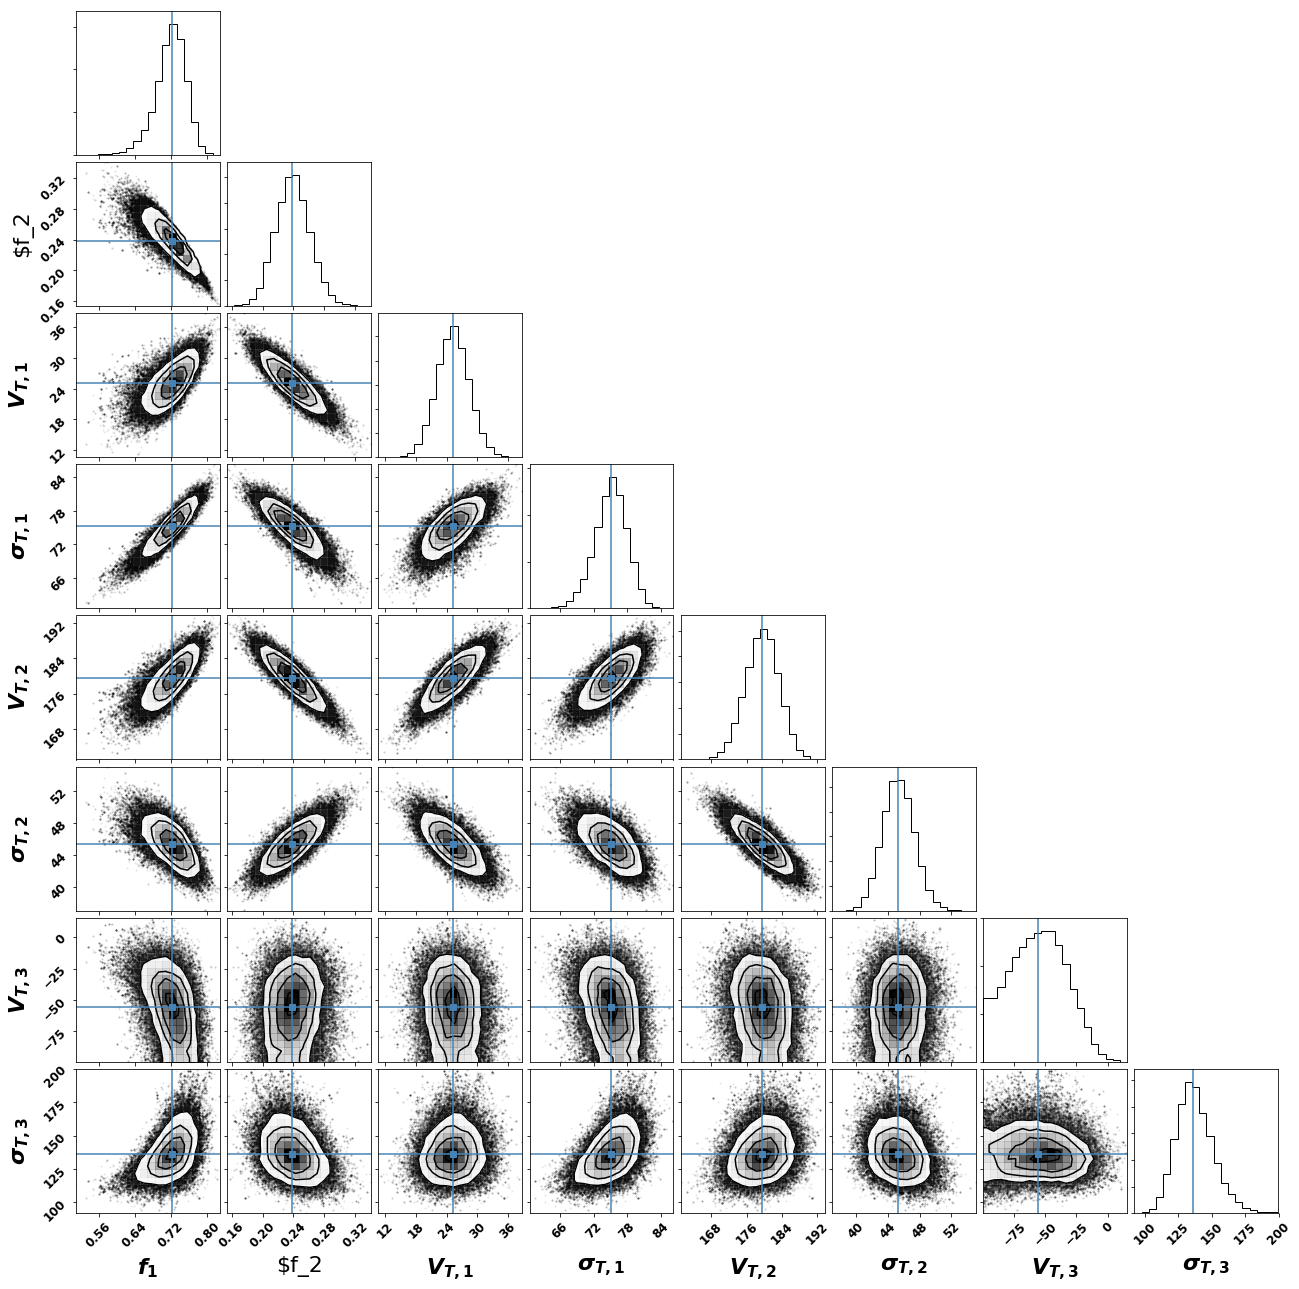

In [32]:
import corner
ss = np.sqrt(np.diag(Mpcov3))
print(ss)
print('f_1=%(f1).3f\pm%(f1e).3f,f_2=%(f2).3f\pm%(f2e).3f,' % {'f1':Mpopt3[0],'f1e':ss[0],'f2':Mpopt3[1],'f2e':ss[1]})
print('v_1=%(v1).0f \pm %(v1e).0f km/s,\sigma_1=%(s1).0f \pm %(s1e).0f km/s' % {'v1':Mpopt3[2],'v1e':ss[2],\
                                                    's1':Mpopt3[3],'s1e':ss[3]})
print('v_2=%(v2).0f \pm %(v2e).0f km/s,\sigma_2=%(s2).0f \pm %(s2e).0f km/s' % {'v2':Mpopt3[4],'v2e':ss[4],\
                                                    's2':Mpopt3[5],'s2e':ss[5]})
print('v_3=%(v3).0f \pm %(v3e).0f km/s,\sigma_3=%(s3).0f \pm %(s3e).0f km/s' % {'v3':Mpopt3[6],'v3e':ss[6],\
                                                    's3':Mpopt3[7],'s3e':ss[7]})
fig = corner.corner(samples3,labels=["$f_1$","$f_2$","$V_{T,1}$","$\sigma_{T,1}$","$V_{T,2}$","$\sigma_{T,2}$",\
                                    "$V_{T,3}$","$\sigma_{T,3}$"],fontsize=15,\
                   truths=Mpopt3)
# fig.savefig('/share/data/cliu/pyw/rot_halo/rothalo_mcmc_result_all.eps',bbox_inches='tight')
fig.savefig('/Users/htian/Documents/work/plots/rothalo/rothalo_mcmc_result_all.eps',bbox_inches='tight')

/Users/htian/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


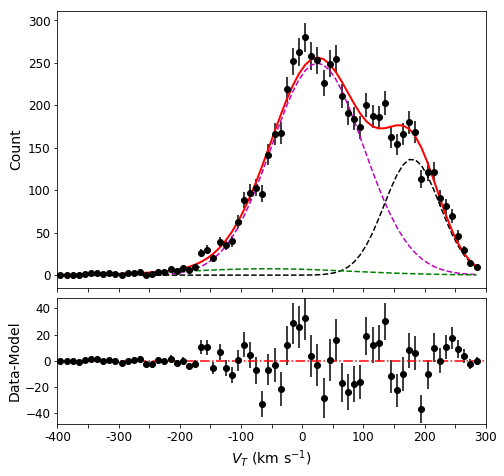

In [11]:
vgrid = np.arange(-400,300,10.)
vcenter = (vgrid[:-1]+vgrid[1:])/2.
fig = plt.figure(figsize=[7,7])
ax = fig.add_axes([0.13,0.4,0.85,0.55])
h,xedge = np.histogram(vt,vgrid)
ax.errorbar(vcenter, h, yerr=np.sqrt(h),fmt='ko')
g1 = Mpopt3[0]*stats.norm.pdf(vcenter,Mpopt3[2],Mpopt3[3])
g2 = Mpopt3[1]*stats.norm.pdf(vcenter,Mpopt3[4],Mpopt3[5])
g3 = (1-Mpopt3[0]-Mpopt3[1])*stats.norm.pdf(vcenter,Mpopt3[6],Mpopt3[7])
g = g1+g2+g3
ax.plot(vcenter, g1/np.sum(g)*np.sum(h),'m--')
ax.plot(vcenter, g2/np.sum(g)*np.sum(h),'k--')
ax.plot(vcenter, g3/np.sum(g)*np.sum(h),'g--')
ax.plot(vcenter, g/np.sum(g)*np.sum(h),'r-',linewidth=2)

ax.set_xlim([-400,300])
ax.set_xticks(np.arange(-400,350,50))
ax.set_xticklabels([])
ax.set_ylabel(r'Count',fontsize=14)

ax = fig.add_axes([0.13,0.13,0.85,0.25])
ax.errorbar(vcenter, h-g/np.sum(g)*np.sum(h),yerr=np.sqrt(h),fmt='ko')
ax.plot([-400,300],[0,0],'r-.')
ax.set_xlim([-400,300])
ax.set_xticks(np.arange(-400,350,50))
ax.set_xticklabels(['-400','','-300','','-200','','-100','','0','','100','','200','','300'])
ax.set_ylim([-48,48])
ax.set_ylabel('Data-Model',fontsize=14)
ax.set_xlabel(r'$V_T$ (km s$^{-1}$)',fontsize=14)
fig.show()

# fig.savefig('/share/data/cliu/pyw/rot_halo/rothalo_vt_distribution.eps',bbox_inches='tight')
fig.savefig('/Users/htian/Documents/work/plots/rothalo/rothalo_vt_distribution.eps',bbox_inches='tight')



In [12]:
fehgrid = np.arange(-2.5,-0.7,0.3)
print(fehgrid)

[-2.5 -2.2 -1.9 -1.6 -1.3 -1. ]


In [13]:
#f_1=0.722\pm0.034,f_2=0.239\pm0.022,
#v_1=25 \pm 3 km/s,\sigma_1=75 \pm 3 km/s
#v_2=179 \pm 4 km/s,\sigma_2=45 \pm 2 km/s
#v_3=-57 \pm 23 km/s,\sigma_3=137 \pm 14 km/s

def lnprob_gauss3m(x,y):
    #n = np.float(len(y))
    f1 = x[0]
    f2 = x[1]
    mu1 = x[2]
    sig1 = x[3]
    mu2 = x[4]
    sig2 = x[5]
    mu3 = x[6]
    sig3 = x[7]
    
    if np.isinf(f1) or np.isinf(f2) or np.isinf(mu1) or np.isinf(sig1) or\
                np.isinf(mu2) or np.isinf(sig2) or np.isinf(mu3) or np.isinf(sig3) or\
                f1<0 or f1>1 or f2<0 or f2>1 or (f1+f2)<0 or (f1+f2)>1 or\
                sig1<60 or sig2<30 or sig3<100 or\
                sig1>120 or sig2>100 or sig3>200 or\
                mu1>50 or mu1<0 or mu2>250 or mu2<140 or mu3>0 or mu3<-100:
        #print('.',end='')
        return -1e100
    g1 = f1*stats.norm.pdf(y,mu1,sig1)# np.exp(-(y-mu1)**2/(2*sig1**2))/(np.sqrt(2*np.pi)*sig1)
    g2 = f2*stats.norm.pdf(y,mu2,sig2)#np.exp(-(y-mu2)**2/(2*sig2**2))/(np.sqrt(2*np.pi)*sig2)
    g3 = (1-f1-f2)*stats.norm.pdf(y,mu3,sig3)#np.exp(-(y-mu2)**2/(2*sig2**2))/(np.sqrt(2*np.pi)*sig2)
    g = g1+g2+g3
    #print g
    ind_g = (np.isinf(g)==False) & (np.isnan(g)==False) & (g>0)
    logg = np.log(g[ind_g])
    ind_lg = logg>-1e100
    #print('+',end='')
    return np.sum(logg[ind_lg])

def gauss3m_model(y,p0,N, func, nwalkers):
    # MCMC sampling
    ndim = p0.shape[1]
    print(ndim)
    sampler = emcee.EnsembleSampler(nwalkers, \
            ndim, func,a = 1.8, args=[y])
    N_burn_in = 2000
    
    pos, prob, state = sampler.run_mcmc(p0, N_burn_in)
    sampler.reset()
    
    sampler.run_mcmc(pos, N)
    
    samples = sampler.chain[:, N_burn_in:, :].reshape((-1, ndim))
    #corner.corner(samples)
    popt = np.median(samples, axis=0)
    pcov = np.zeros((ndim,ndim))
    for i in range(ndim):
        for j in range(ndim):
            pcov[i,j] = (np.sum((samples[:,i]-popt[i])*\
                (samples[:,j]-popt[j])))/len(samples)
    return popt, pcov, samples



#print(lnprob_gauss3([0.6,0.1,30.,80.,180.,60,20,30.],vt))
nwalkers = 20
results_m = []
for i in range(len(fehgrid)-1):
    p0=np.zeros((nwalkers,ndim))
    p0[:,0] = np.random.rand(nwalkers)*0.2+0.6
    p0[:,1] = np.random.rand(nwalkers)*0.2+0.1
    p0[:,2] = np.random.rand(nwalkers)*40+10
    p0[:,3] = np.random.rand(nwalkers)*30+60
    p0[:,4] = np.random.rand(nwalkers)*50+150
    p0[:,5] = np.random.rand(nwalkers)*40+30
    p0[:,6] = np.random.rand(nwalkers)*100-100
    p0[:,7] = np.random.rand(nwalkers)*60+100
    start = time.time()
    ind = (feh>=fehgrid[i]) & (feh<fehgrid[i+1])
    Mpopt3m,Mpcov3m, samples3m = gauss3m_model(vt[ind], p0, 8000, lnprob_gauss3m, nwalkers)
    results_m.append([Mpopt3m,Mpcov3m,samples3m])
    print(Mpopt3m)
    print(fehgrid[i],time.time()-start)
    

8
[  6.05580095e-01   5.28852980e-02   3.43557787e+01   7.53555291e+01
   1.94123993e+02   6.30320278e+01  -3.44394171e+01   1.16719886e+02]
-2.5 37.890552043914795
8
[  7.58563928e-01   8.32140214e-02   3.45770721e+01   8.94885485e+01
   1.59645326e+02   5.47078173e+01  -4.47394803e+01   1.19248922e+02]
-2.2 45.282434940338135
8
[  8.40522565e-01   8.18484190e-02   2.71048423e+01   8.51640083e+01
   1.56772503e+02   5.16057929e+01  -4.64961166e+01   1.25720839e+02]
-1.9 54.32505798339844
8
[  7.91110588e-01   1.72296748e-01   1.85902678e+01   6.88017102e+01
   1.73863750e+02   4.67161761e+01  -6.79458447e+01   1.56420677e+02]
-1.6 77.55315613746643
8
[   0.55111865    0.41964837   20.73003366   64.19368969  176.41147307
   46.71086459  -18.08321482  122.09893483]
-1.3 84.80177283287048


In [14]:
np.sqrt(np.diag(Mpcov3m))

array([  3.25367448e-02,   2.29024193e-02,   3.97908244e+00,
         3.18198786e+00,   3.05398662e+00,   1.87823710e+00,
         2.21231549e+01,   2.44971592e+01])

In [15]:
result_m_tab = np.zeros((len(fehgrid)-1,17))
for i in range(len(fehgrid)-1):
    [Mpopt3m,Mpcov3m,sample3m] = results_m[i]
    ss = np.sqrt(np.diag(Mpcov3m))
    print(ss)
    print('f_1=%(f1).3f\pm%(f1e).3f,f_2=%(f2).3f\pm%(f2e).3f,' % {'f1':Mpopt3m[0],'f1e':ss[0],'f2':Mpopt3m[1],'f2e':ss[1]})
    print('v_1=%(v1).0f \pm %(v1e).0f km/s,\sigma_1=%(s1).0f \pm %(s1e).0f km/s' % {'v1':Mpopt3m[2],'v1e':ss[2],\
                                                        's1':Mpopt3m[3],'s1e':ss[3]})
    print('v_2=%(v2).0f \pm %(v2e).0f km/s,\sigma_2=%(s2).0f \pm %(s2e).0f km/s' % {'v2':Mpopt3m[4],'v2e':ss[4],\
                                                        's2':Mpopt3m[5],'s2e':ss[5]})
    print('v_3=%(v3).0f \pm %(v3e).0f km/s,\sigma_3=%(s3).0f \pm %(s3e).0f km/s' % {'v3':Mpopt3m[6],'v3e':ss[6],\
                                                        's3':Mpopt3m[7],'s3e':ss[7]})
    result_m_tab[i,:]=np.array([fehgrid[i],Mpopt3m[0],Mpopt3m[1],\
                       Mpopt3m[2],Mpopt3m[3],Mpopt3m[4],Mpopt3m[5],Mpopt3m[6],\
                      Mpopt3m[7],ss[0],ss[1],ss[2],ss[3],ss[4],ss[5],ss[6],ss[7]])

[  0.16460584   0.03997877  11.70094168  12.67909571  31.35409147
  19.52221379  26.1504189   18.48657075]
f_1=0.606\pm0.165,f_2=0.053\pm0.040,
v_1=34 \pm 12 km/s,\sigma_1=75 \pm 13 km/s
v_2=194 \pm 31 km/s,\sigma_2=63 \pm 20 km/s
v_3=-34 \pm 26 km/s,\sigma_3=117 \pm 18 km/s
[  0.14985351   0.0640082   10.75097703   9.25229527  25.30652358
  12.82555208  26.81729023  22.05536171]
f_1=0.759\pm0.150,f_2=0.083\pm0.064,
v_1=35 \pm 11 km/s,\sigma_1=89 \pm 9 km/s
v_2=160 \pm 25 km/s,\sigma_2=55 \pm 13 km/s
v_3=-45 \pm 27 km/s,\sigma_3=119 \pm 22 km/s
[  0.09169208   0.05209704   8.23727638   5.59849832  16.82989714
  10.25941873  27.56278007  22.03629565]
f_1=0.841\pm0.092,f_2=0.082\pm0.052,
v_1=27 \pm 8 km/s,\sigma_1=85 \pm 6 km/s
v_2=157 \pm 17 km/s,\sigma_2=52 \pm 10 km/s
v_3=-46 \pm 28 km/s,\sigma_3=126 \pm 22 km/s
[  0.0446017    0.03938511   5.16599317   3.76528647  11.08012066
   5.6339257   23.8564922   19.84107903]
f_1=0.791\pm0.045,f_2=0.172\pm0.039,
v_1=19 \pm 5 km/s,\sigma_1=69 \

In [16]:
print(result_m_tab)

[[ -2.50000000e+00   6.05580095e-01   5.28852980e-02   3.43557787e+01
    7.53555291e+01   1.94123993e+02   6.30320278e+01  -3.44394171e+01
    1.16719886e+02   1.64605839e-01   3.99787682e-02   1.17009417e+01
    1.26790957e+01   3.13540915e+01   1.95222138e+01   2.61504189e+01
    1.84865708e+01]
 [ -2.20000000e+00   7.58563928e-01   8.32140214e-02   3.45770721e+01
    8.94885485e+01   1.59645326e+02   5.47078173e+01  -4.47394803e+01
    1.19248922e+02   1.49853511e-01   6.40082010e-02   1.07509770e+01
    9.25229527e+00   2.53065236e+01   1.28255521e+01   2.68172902e+01
    2.20553617e+01]
 [ -1.90000000e+00   8.40522565e-01   8.18484190e-02   2.71048423e+01
    8.51640083e+01   1.56772503e+02   5.16057929e+01  -4.64961166e+01
    1.25720839e+02   9.16920839e-02   5.20970364e-02   8.23727638e+00
    5.59849832e+00   1.68298971e+01   1.02594187e+01   2.75627801e+01
    2.20362957e+01]
 [ -1.60000000e+00   7.91110588e-01   1.72296748e-01   1.85902678e+01
    6.88017102e+01   1.7386375

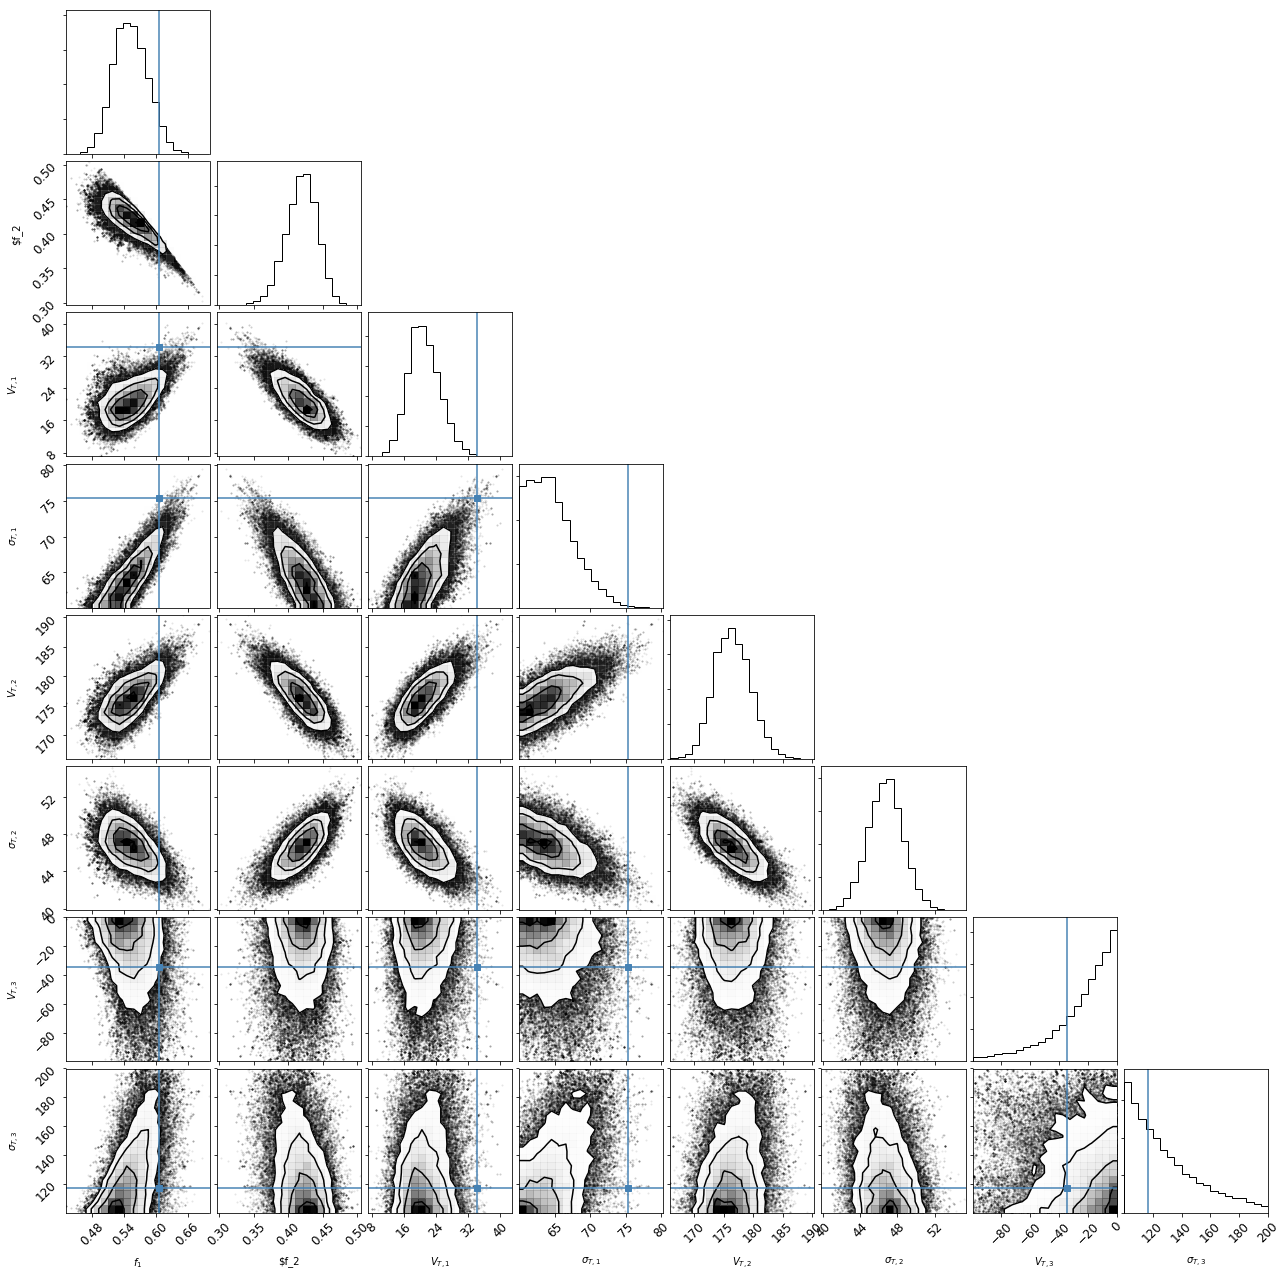

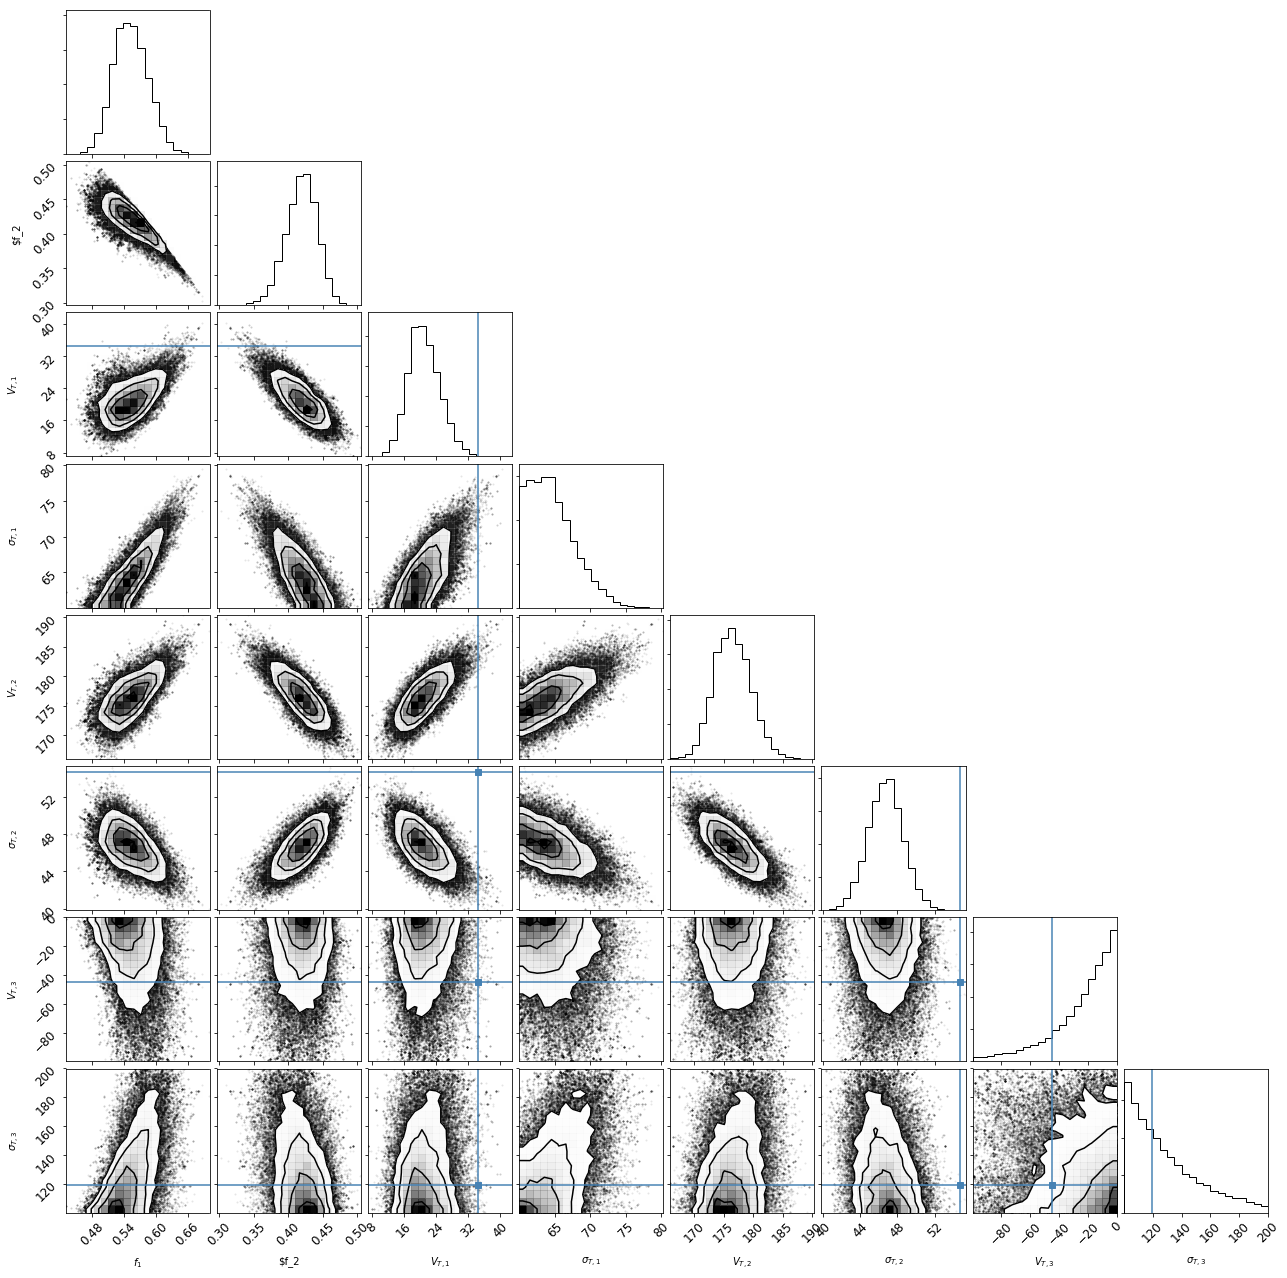

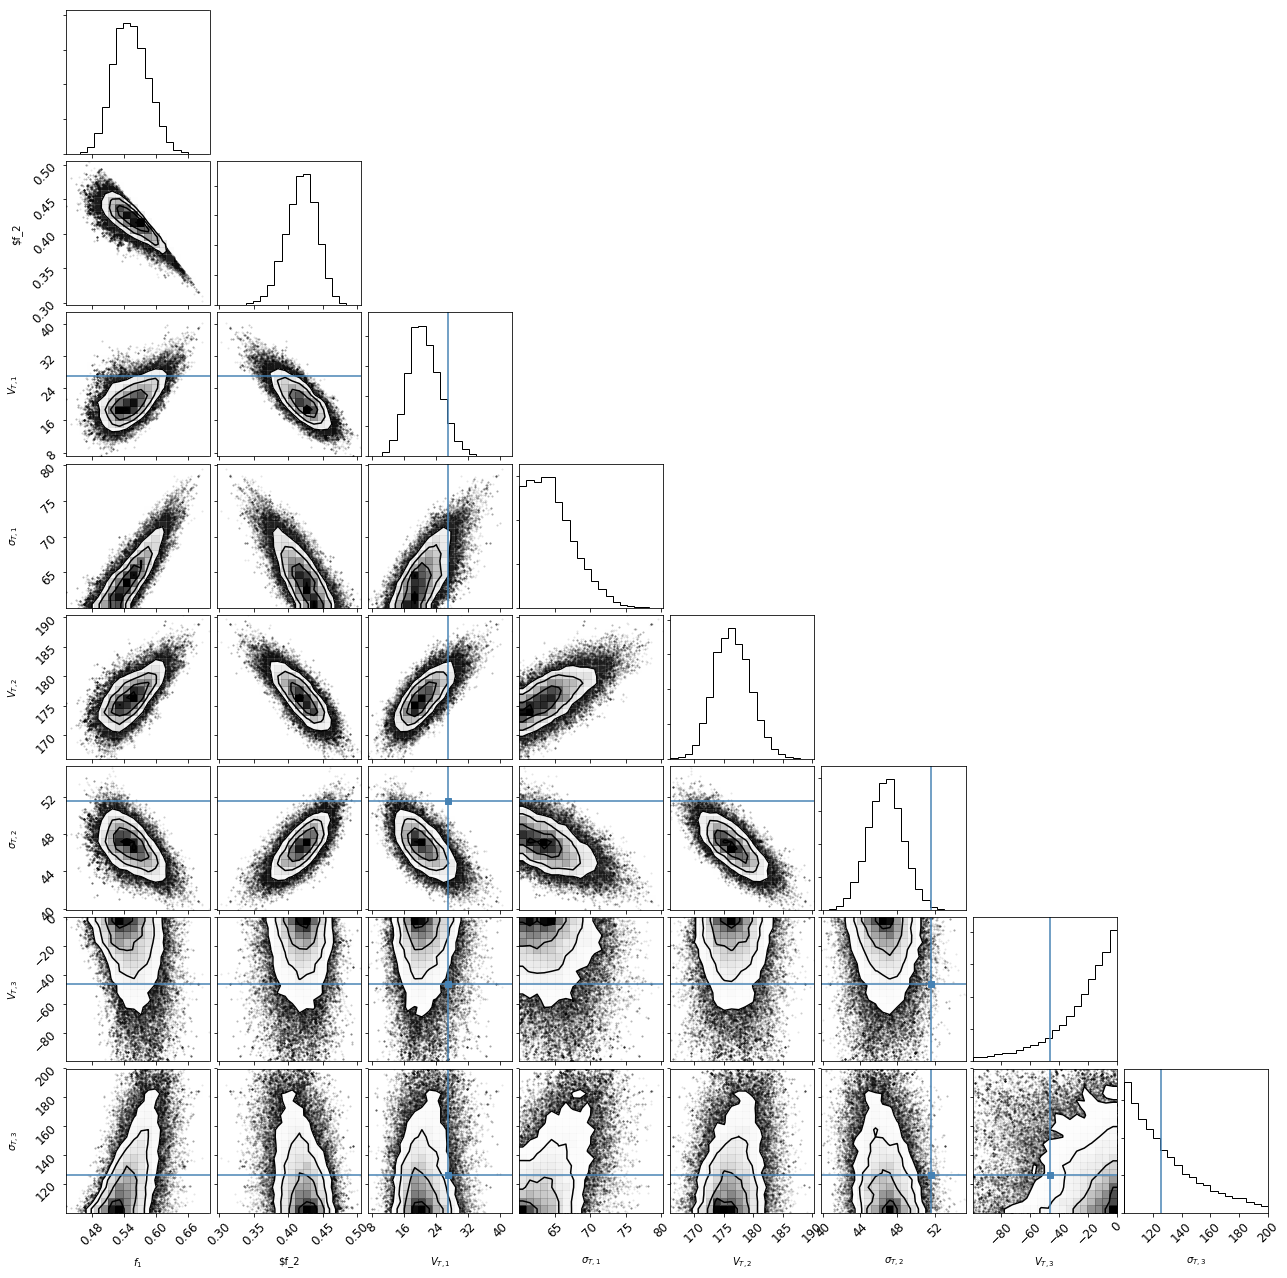

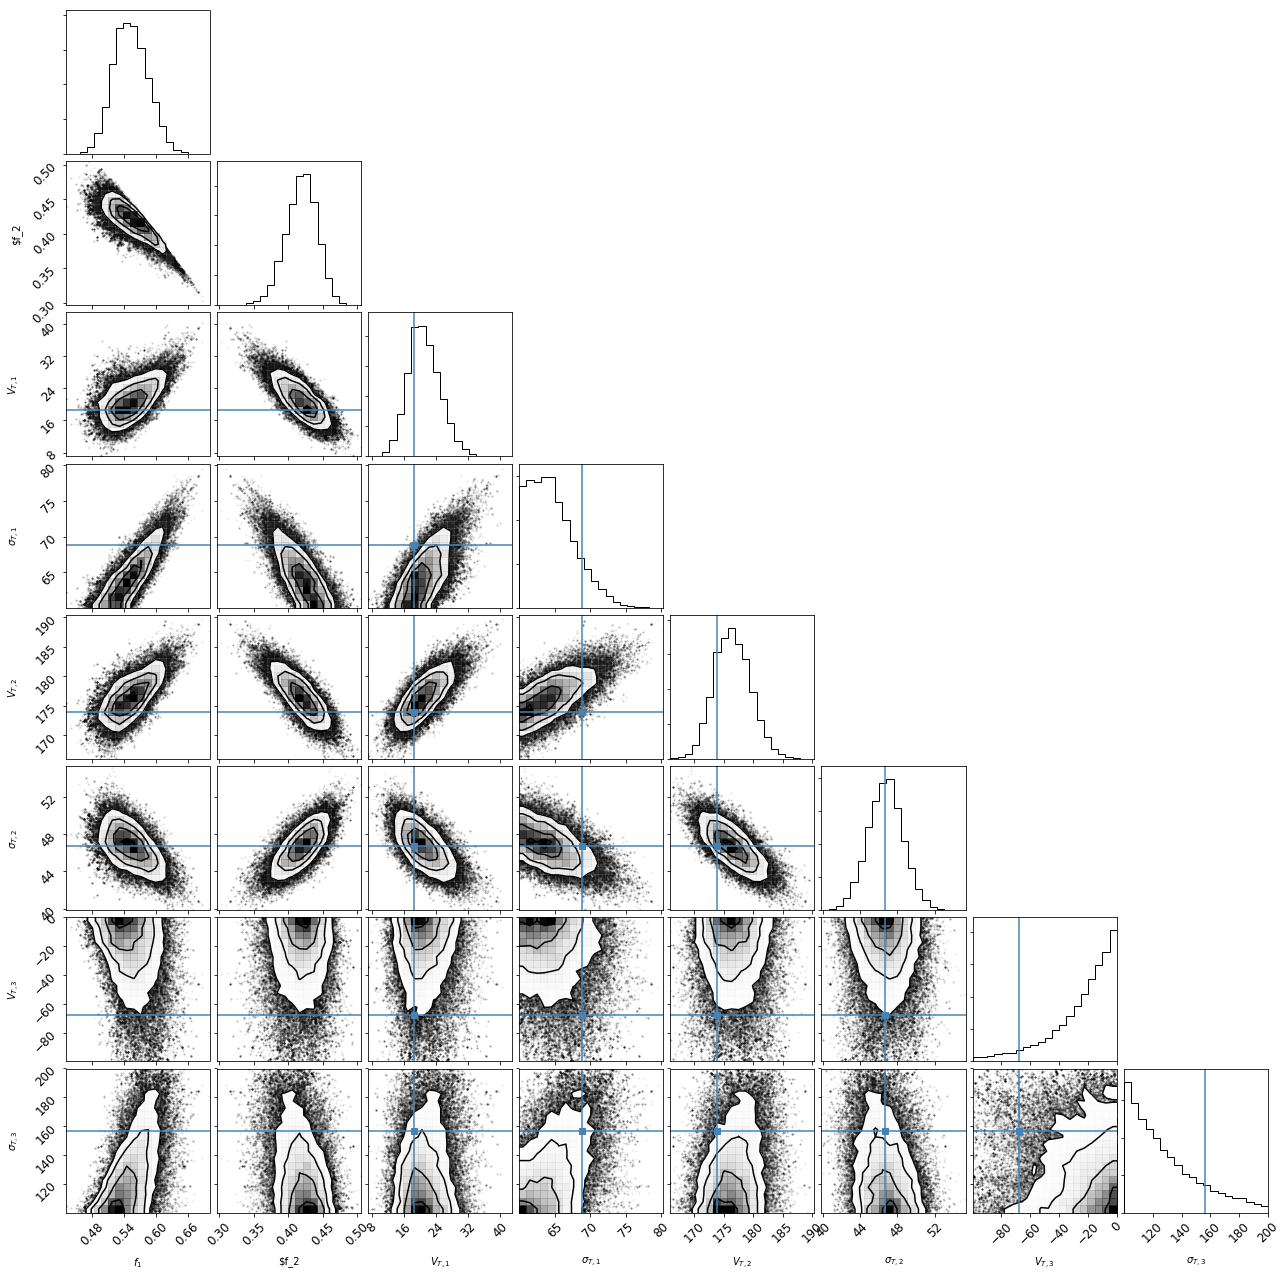

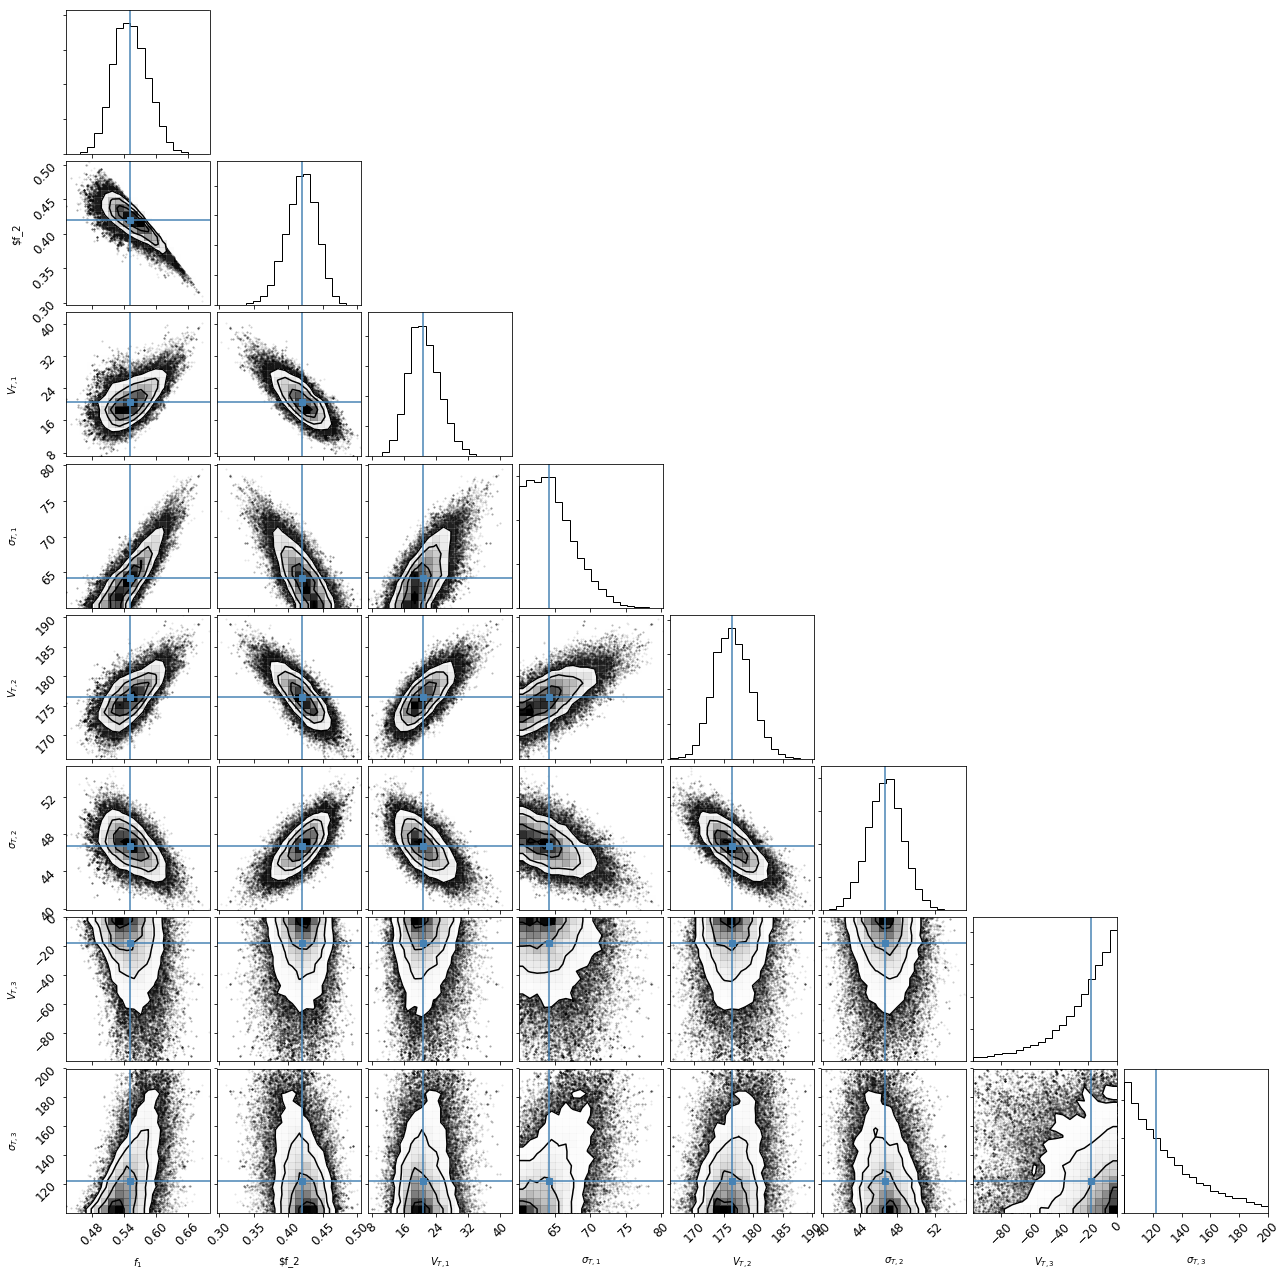

In [17]:
for i in range(len(fehgrid)-1):
    [Mpopt3m,Mpcov3m,sample3m] = results_m[i]
    fig = corner.corner(samples3m,labels=["$f_1$","$f_2","$V_{T,1}$","$\sigma_{T,1}$","$V_{T,2}$","$\sigma_{T,2}$",\
                                        "$V_{T,3}$","$\sigma_{T,3}$"],\
                       truths=Mpopt3m)
    #fig.savefig('/share/data/cliu/pyw/rot_halo/rothalo_mcmc_result_feh%(m).3f.eps' % {'m':fehgrid[i]},bbox_inches='tight')